In [1]:
!pip install torch~=2.4.0 torch_xla[tpu]~=2.4.0 -f https://storage.googleapis.com/libtpu-releases/index.html
!pip uninstall -y tensorflow && pip install tensorflow-cpu

Looking in links: https://storage.googleapis.com/libtpu-releases/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.2/116.2 MB 6.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: libtpu-nightly
    Found existing installation: libtpu-nightly 0.1.dev20231213
    Uninstalling libtpu-nightly-0.1.dev20231213:
      Successfully uninstalled libtpu-nightly-0.1.dev20231213

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Successfully uninstalled tensorflow-2.16.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.2/221.2 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 9.0 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2

[notice] A new release of p

In [2]:
import tensorflow as tf
import torch
import torch_xla
import torch_xla.core.xla_model as xm
from tensorflow.data import TFRecordDataset


print("PyTorch version:", torch.__version__)
print("PyTorch/XLA version:", torch_xla.__version__)

PyTorch version: 2.4.0+cu121
PyTorch/XLA version: 2.4.0+libtpu


In [3]:
import os


# Список файлов в директории
print(os.listdir("/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"))

['val', 'test', 'train']


In [5]:
import numpy as np
from albumentations import (
    Blur,
    CoarseDropout,
    Compose,
    GaussNoise,
    HorizontalFlip,
    HueSaturationValue,
    Normalize,
    Resize,
    ShiftScaleRotate,
)
from albumentations.pytorch import ToTensorV2


def transform_image(image, is_train=True):
    image = image.numpy().astype(np.uint8)

    mean = [0.45397732, 0.42053542, 0.29964647]
    std = [0.24271463, 0.21145713, 0.21939221]

    if is_train:
        transforms = Compose(
            [
                Resize(*(224, 224, 3)),  # for mobilenetv4_hybrid_medium.e500_r224_in1k (train)
                HorizontalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(
                    hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5
                ),
                CoarseDropout(max_holes=3, max_height=32, max_width=32, p=0.25),
                Blur(blur_limit=3, p=0.25),
                GaussNoise(p=0.25),
                Normalize(mean=mean, std=std),
                ToTensorV2(),
            ]
        )
    else:
        transforms = Compose(
            [
                Resize(*(256, 256, 3)),  # for mobilenetv4_hybrid_medium.e500_r224_in1k (test)
                Normalize(mean=mean, std=std),
                ToTensorV2(),
            ]
        )

    transformed = transforms(image=image)
    return transformed["image"]


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    label = example["class"]
    return image, label


def read_unlabeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    id_ = example["id"]
    return image, id_


"""
def load_dataset(filenames, labeled=True, ordered=False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    maped_dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord) # a dataset of (image, label) pairs if labeled=True or (image, id) if labeled=False
    for elem in maped_dataset:
        yield elem
        
def load_tensor_batches(generator_dataset, batch_size=128, labeled=True, is_train=True):
    i = 0
    batch_imgs, batch_lbls = list(), list()
    for elem in generator_dataset:
        img = transform_image(image=elem[0], is_train=is_train).type(torch.float32)
        lbl = torch.tensor(elem[1].numpy(), dtype=torch.float32) if labeled else elem[1].numpy().decode('utf-8')
        batch_imgs.append(img)
        batch_lbls.append(lbl)
        i += 1
        if i % batch_size == 0:
                yield torch.stack(batch_imgs), torch.stack(batch_lbls) if labeled else batch_lbls
                batch_imgs, batch_lbls = list(), list()
"""


def get_recursive_paths(path, mode="train"):
    list_filePath = list()
    for folder, subfolders, files in os.walk(os.path.join(path, mode)):
        for file in files:
            filePath = os.path.abspath(os.path.join(folder, file))
            if ".tfrec" in filePath.split("/")[-1]:
                list_filePath.append(filePath)
    return list_filePath

In [6]:
path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"

train_trf_dataset = load_dataset(get_recursive_paths(path, "train"))

In [7]:
train_trf_dataset

<generator object load_dataset at 0x78afeb73ceb0>

In [8]:
import matplotlib.pyplot as plt


path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"
train_trf_dataset = load_dataset(get_recursive_paths(path, "test"), labeled=False)

batch_train_tensors = next(load_tensor_batches(train_trf_dataset, labeled=False, is_train=False))

In [9]:
batch_train_tensors[0].shape

torch.Size([128, 3, 256, 256])

cac4474ff


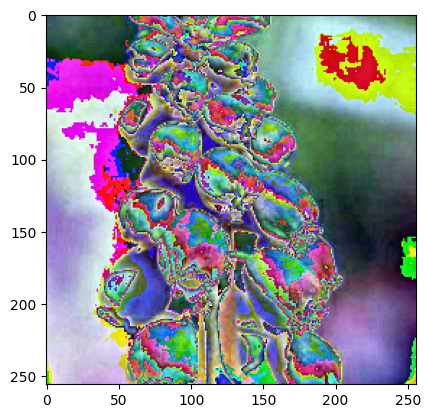

In [10]:
import random

import numpy as np


batch_imgs, batch_lbls = batch_train_tensors
batch_imgs_np = [(image.permute(1, 2, 0) * 255.0).numpy().astype(np.uint8) for image in batch_imgs]

rand_id = random.randrange(0, len(batch_imgs_np))
print(batch_lbls[rand_id])
plt.imshow(batch_imgs_np[rand_id])

In [ ]:
xm.get_xla_supported_devices()

In [ ]:
device = xm.xla_device() if xm.get_xla_supported_devices() else "cpu"
device

In [6]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 16.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 34.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.8/446.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 10.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [7]:
import math

import lightning
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from tqdm import tqdm


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(start_dim=1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 104),
        )

    def forward(self, x):
        return self.model(x)


class LitModel(lightning.LightningModule):
    def __init__(self, device="cpu"):
        super().__init__()
        self.encoder = Encoder()
        self.loss_fn = nn.NLLLoss()
        self.lr = 5e-3
        self.device = device
        self.activation = F.log_softmax()

    def forward(self, x):
        return self.encoder(x)

    def training_step(self, train_batch, batch_idx):
        train_imgs, train_lbls = train_batch[0].to(self.device, dtype=torch.float32), train_batch[
            1
        ].to(self.device, dtype=torch.float32)

        predict_probas = self.activation(self(train_imgs), dim=1)
        loss = self.loss_fn(predict_probas, train_lbls)
        self.log("train_loss", loss)
        train_f1_score = metrics.f1_score(
            train_lbls.detach().cpu().numpy(),
            torch.argmax(predict_probas, dim=1).detach().cpu().numpy(),
            average="macro",
        )
        self.log("train_f1-score", train_f1_score)
        return loss

    # def validation_step(self, batch, batch_idx):
    #    val_imgs, val_lbls = batch
    #    lbls_predict = self(val_imgs)
    #    loss = self.loss_fn(lbls_predict, val_lbls)
    #    self.log('val_loss', loss)

    #    f1 = metrics.f1_score(val_lbls.detach().cpu().numpy(), torch.argmax(lbls_predict, dim=1).detach().cpu().numpy(), average="macro")
    #    self.log('val_f1', f1)

    # def configure_optimizers(self):
    #    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)
    #    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    #    return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_loss'}}

In [ ]:
num_epochs = 100
batch_size = 512


def try_train_steps(i, lock, train_losses, val_losses):
    global num_epochs, batch_size

    device = xm.xla_device() if xm.get_xla_supported_devices() else "cpu"
    xlm_model = LitModel(device).to(device, dtype=torch.float32)

In [ ]:
import multiprocessing as mp
from multiprocessing import Array

import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp


lock = mp.Manager().Lock()
train_losses, val_losses = mp.Manager().list(), mp.Manager().list()

try:
    os.environ.pop("TPU_PROCESS_ADDRESSES")
except KeyError:
    print("already done")
try:
    os.environ.pop("CLOUD_TPU_TASK_ID")
except KeyError:
    print("already done")

if __name__ == "__main__":
    xmp.spawn(try_train_steps, args=(lock, train_losses, val_losses), start_method="fork")

In [9]:
import time

import torch_xla.distributed.parallel_loader as pl
from torch.utils.data import DataLoader, Dataset


start_time = time.time()


class CustomDataset(Dataset):
    def __init__(self, file_paths, mode="train", ordered=False):
        self.file_paths = file_paths
        self.mode = mode
        self.labeled = (
            True
            if self.mode
            in [
                "train",
                "val",
            ]
            else False
        )
        self.is_train = (
            True
            if self.mode
            in [
                "train",
            ]
            else False
        )
        self.tfr_dataset = tf.data.TFRecordDataset(self.file_paths)

        ignore_order = tf.data.Options()
        if not ordered:
            ignore_order.experimental_deterministic = False

        self.tfr_dataset = list(self.tfr_dataset.with_options(ignore_order))

    def __len__(self):
        return len(self.tfr_dataset)

    def __getitem__(self, idx):
        example = self.tfr_dataset[idx]
        image, label = (
            read_labeled_tfrecord(example) if self.labeled else read_unlabeled_tfrecord(example)
        )

        transformed_image = transform_image(image, is_train=self.is_train)

        if self.labeled:
            return transformed_image, torch.tensor(label.numpy(), dtype=torch.float32)
        else:
            return transformed_image, label.numpy().decode("utf-8")


path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"
mode = "train"
batch_size = 512

custom_dataset = CustomDataset(file_paths=get_recursive_paths(path, mode), mode=mode)
train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
device = xm.xla_device() if xm.get_xla_supported_devices() else "cpu"
train_loader_parallel = pl.ParallelLoader(train_loader, [device])

for images, labels in train_loader_parallel.per_device_loader(xm.xla_device()):
    print(labels.shape)
    print(images.shape)
    # plt.imshow(images[0].permute(1,2,0).detach().cpu().numpy())
    # plt.show()

end_time = time.time()

print(end_time - start_time)

torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
torch.Size([512, 3, 224, 224])
torch.Size([512])
to

In [16]:
import math

import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from tqdm import tqdm


class xlm_fully_conv(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(start_dim=1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 104),
        )

    def forward(self, batch):
        return F.log_softmax(self.model(batch), dim=1)

In [17]:
xlm_model = xlm_fully_conv().to(device, dtype=torch.float32)
output = xlm_model(batch_train_tensors[0].to(device, dtype=torch.float32))

In [18]:
print(sorted(np.unique(torch.argmax(output, dim=1).detach().cpu().numpy())))

[0, 3, 7, 11, 12, 14, 15, 18, 19, 20, 22, 23, 25, 26, 27, 28, 29, 34, 38, 39, 40, 42, 43, 44, 45, 48, 50, 51, 52, 53, 54, 56, 59, 60, 65, 67, 68, 75, 77, 78, 79, 80, 82, 83, 88, 93, 97, 98, 99, 103]


In [ ]:
from collections import deque

import torch_xla.distributed.parallel_loader as pl
from sklearn import metrics
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm


num_epochs = 100
loss = nn.NLLLoss()
batch_size = 512


def train_val_pipeline(i, lock, train_losses, val_losses):
    global num_epochs, loss, batch_size

    device = xm.xla_device() if xm.get_xla_supported_devices() else "cpu"
    xlm_model = xlm_fully_conv().to(device, dtype=torch.float32)
    opt = torch.optim.Adam(xlm_model.parameters(), lr=5e-3, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)
    rate_tracker_train = xm.RateTracker()
    rate_tracker_val = xm.RateTracker()

    for epoch in range(num_epochs):
        with lock:
            print(f"Epoch: {epoch}")
        xlm_model.train()
        batch_generator_train = load_tensor_batches(
            load_dataset(get_recursive_paths(path, "train")), batch_size, is_train=True
        )
        train_loader = pl.ParallelLoader(batch_generator_train, [device])
        epoch_train_loss = 0

        for iteration, train_batch in enumerate(
            train_loader.per_device_loader(xm.xla_device()), start=1
        ):
            opt.zero_grad()
            with torch_xla.step():
                train_imgs, train_lbls = train_batch[0].to(
                    device, dtype=torch.float32
                ), train_batch[1].to(device, dtype=torch.float32)

                lbls_predict = xlm_model(train_imgs)
                output = loss(lbls_predict, train_lbls)
                output.backward()
                xm.optimizer_step(opt)

                epoch_train_loss += output.item()
                rate_tracker_train.add(batch_size)

                if iteration % 10 == 0:
                    f1 = metrics.f1_score(
                        train_lbls.detach().cpu().numpy(),
                        torch.argmax(lbls_predict, dim=1).detach().cpu().numpy(),
                        average="macro",
                    )
                    with lock:
                        train_losses.append(epoch_train_loss / iteration)
                        print(f"Loss: {output.detach().cpu()}")
                        print(f"F1-score: {f1}")
                        print(f"Rate: {rate_tracker_train.rate()} examples/sec")

            xm.mark_step()

        xlm_model.eval()
        batch_generator_val = load_tensor_batches(
            load_dataset(get_recursive_paths(path, "val")), batch_size, is_train=False
        )
        val_loader = pl.ParallelLoader(batch_generator_val, [device])
        losses, f1scores = deque(), deque()
        epoch_val_loss = 0

        for iteration, val_batch in enumerate(
            val_loader.per_device_loader(xm.xla_device()), start=1
        ):
            with torch_xla.step():
                val_imgs, val_lbls = val_batch[0].to(device, dtype=torch.float32), val_batch[1].to(
                    device, dtype=torch.float32
                )

                with torch.no_grad():
                    lbls_predict = xlm_model(val_imgs)
                    output = loss(lbls_predict, val_lbls)
                    score = metrics.f1_score(
                        val_lbls.detach().cpu().numpy(),
                        torch.argmax(lbls_predict, dim=1).detach().cpu().numpy(),
                        average="macro",
                    )

                    losses.append(output.detach().cpu())
                    f1scores.append(score)
                    rate_tracker_val.add(batch_size)

                    epoch_val_loss += output.item()

            xm.mark_step()

        val_losses.append(epoch_val_loss / iteration)

        scheduler.step(np.mean(np.array(losses)))

        with lock:
            print(f"Validation")
            print(f"Loss: {np.mean(np.array(losses))}")
            print(f"F1-score: {np.mean(np.array(f1scores))}")
            print(f"Rate: {rate_tracker_val.rate()} examples/sec")

In [ ]:
import multiprocessing as mp
from multiprocessing import Array

import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp


lock = mp.Manager().Lock()
train_losses, val_losses = mp.Manager().list(), mp.Manager().list()

try:
    os.environ.pop("TPU_PROCESS_ADDRESSES")
except KeyError:
    print("already done")
try:
    os.environ.pop("CLOUD_TPU_TASK_ID")
except KeyError:
    print("already done")

if __name__ == "__main__":
    xmp.spawn(train_val_pipeline, args=(lock, train_losses, val_losses), start_method="fork")

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(list(train_losses), label="Train Loss")
plt.plot(list(val_losses), label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from collections import defaultdict


xlm_model.eval()
test_data = next(
    load_tensor_batches(
        load_dataset(get_recursive_paths(path, "test"), labeled=False),
        batch_size=1,
        labeled=False,
        is_train=False,
    )
)

test_imgs, test_filename = test_data[0].to(device, dtype=torch.float32), test_data[1]
lbls_predict = xlm_model(test_imgs)

print(int(torch.argmax(lbls_predict, dim=1).detach().cpu().squeeze()), test_filename)

In [ ]:
from collections import defaultdict

import pandas as pd


xlm_model.eval()
test_data = load_tensor_batches(
    load_dataset(get_recursive_paths(path, "test"), labeled=False), batch_size=1, labeled=False
)
test_dataframe = defaultdict(list)

for i, test_batch in enumerate(test_data):
    test_imgs, test_filename = test_batch[0].to(device, dtype=torch.float32), test_batch[1]
    lbls_predict = xlm_model(test_imgs)
    test_dataframe["id"].append(*test_filename)
    test_dataframe["label"].append(int(torch.argmax(lbls_predict, dim=1).detach().cpu().squeeze()))

In [ ]:
solution = pd.DataFrame(test_dataframe).reset_index(drop=True)

In [ ]:
solution.head(5)

In [ ]:
solution.to_csv(f"conv_baseline_solution.csv", index=False)